# Notebook Objectives
- generate synthetic time-series [ using [TimeSynth](https://github.com/TimeSynth/TimeSynth) ]
- visualize data
- pre-process [ split train/test, and normalize ]
- build model 
- train model
- evaluate model


In [0]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

# Generate Synthetic TimeSeries

In [0]:
nSamples = 100000
samplesPerSensorInput = 100

In [151]:
import io
from google.colab import files

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['mainData.csv']))
df.head()

Saving mainData.csv to mainData (2).csv


,Unnamed: 0,co2_1,co2_2,co2_3,co2_4,dew_1,dew_2,dew_3,dew_4,relH_1,relH_2,relH_3,relH_4,temp_1,temp_2,temp_3,temp_4,externTemp_1,externHumid_1,externCondition_1,externSunrise_1
0,2018-01-01 00:00:03-08:00,480.750000,474.886993,477.817993,474.886993,52.214100,51.510899,51.862499,52.038300,73.917000,78.438202,77.531898,76.550697,59.400002,60.000000,58.799999,58.500000,35.0,76.0,4,1
1,2018-01-01 00:15:03-08:00,480.750000,474.886993,474.886993,474.886993,52.389801,51.686699,51.686699,51.862499,74.492798,79.800903,78.598999,76.601303,59.200001,59.799999,58.500000,58.299999,35.0,76.0,4,1
2,2018-01-01 00:30:03-08:00,477.817993,477.817993,474.886993,474.886993,52.214100,51.510899,51.510899,51.862499,74.275002,80.143303,78.370903,76.875603,59.099998,59.700001,58.299999,58.000000,35.0,77.0,4,1
3,2018-01-01 00:45:03-08:00,486.612000,477.817993,474.886993,477.817993,52.038300,51.335201,51.510899,51.510899,75.074402,79.912003,78.990196,76.428596,58.900002,59.400002,58.000000,57.799999,35.0,77.0,4,1
4,2018-01-01 01:00:03-08:00,486.612000,474.886993,477.817993,477.817993,51.862499,51.335201,51.159401,51.335201,74.635696,79.967499,79.274902,76.205597,58.799999,59.200001,57.799999,57.700001,35.0,77.0,4,1


In [154]:
S1.shape

(32834, 1)

In [155]:
startRef = 2100
endRef = 3100

S1 = df[startRef:]['co2_2']
S2 = df[startRef:]['co2_2']
S3 = df[startRef:]['co2_2']


'''
S1 = df['co2_1']
S2 = df['co2_2']
S3 = df['co2_3']
'''

"\nS1 = df['co2_1']\nS2 = df['co2_2']\nS3 = df['co2_3']\n"

In [0]:
S1 = np.transpose(np.expand_dims(S1,axis=0))
S2 = np.transpose(np.expand_dims(S2,axis=0))
S3 = np.transpose(np.expand_dims(S3,axis=0))

# Visualize Data at Multiple Scales

In [0]:
def plot_data ( data ):    
    plt.figure(figsize = (10,15));     
    plt.subplot(4,1,1); plt.plot(data); plt.title('all data')
    plt.subplot(4,1,2); plt.plot(data[0:int(data.shape[0]//10.0)]); plt.title('first 10%')
    plt.subplot(4,1,3); plt.plot(data[0:int(data.shape[0]//100.0)]); plt.title('first 1%')
    plt.subplot(4,1,4); plt.plot(data[0:int(data.shape[0]//1000.0)], '-x'); plt.title('first .1%')    

(None, None, None)

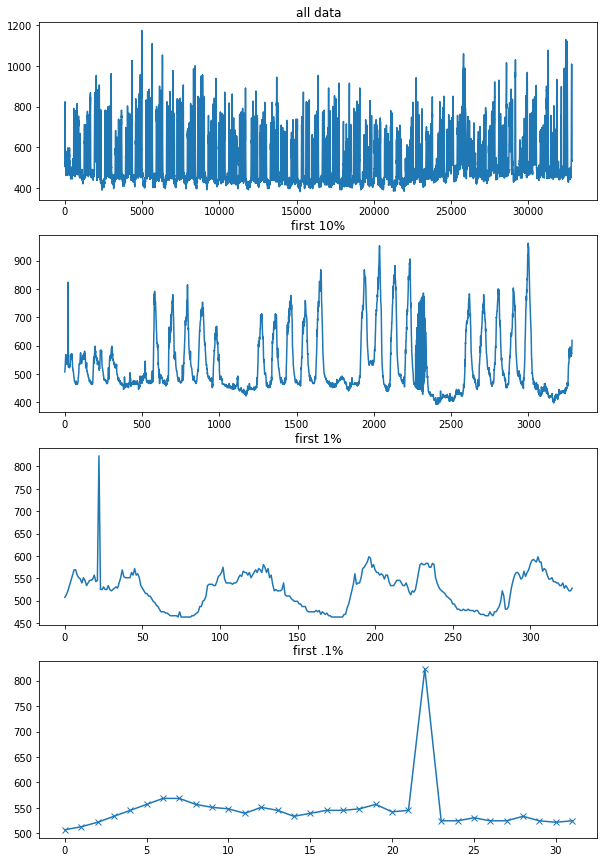

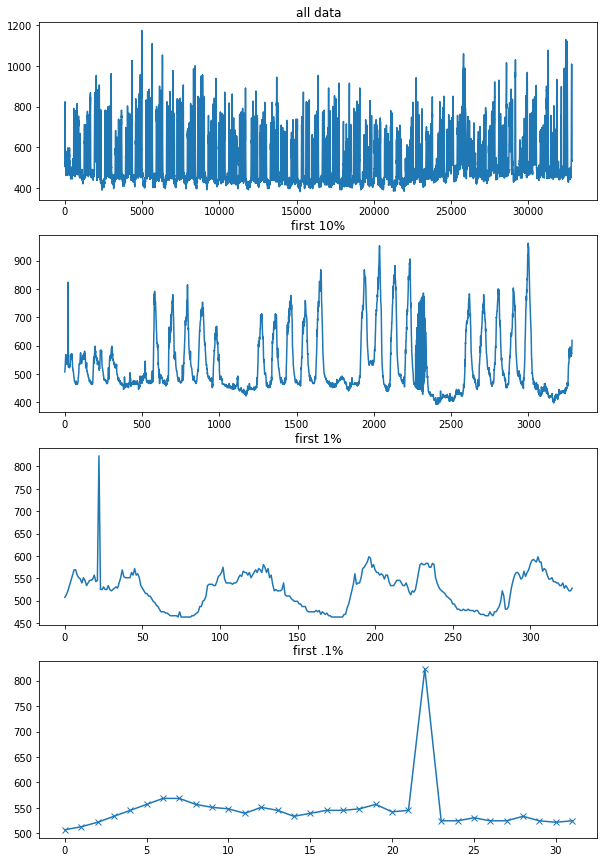

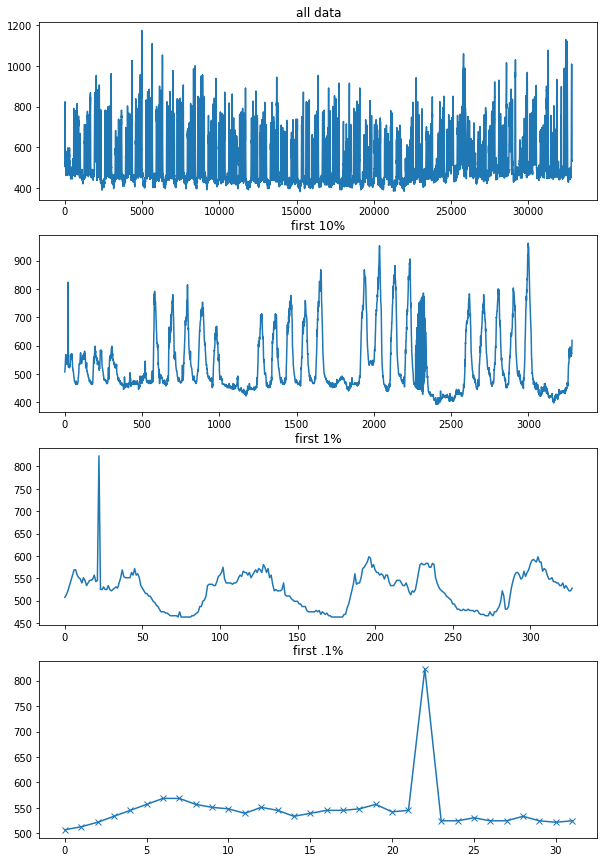

In [158]:
plot_data(S1), plot_data(S2), plot_data(S3)

# Data Prep -- split and normalize

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [0]:
def split_and_rescale ( X ):
    X_train, X_test = train_test_split( X, test_size = .25, shuffle = False )
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform( X_train )
    X_test_scaled = scaler.transform( X_test )
    return X_train_scaled, X_test_scaled

In [0]:
S1_train_scaled, S3_test_scaled = split_and_rescale(S1)
S2_train_scaled, S2_test_scaled = split_and_rescale(S2)
S3_train_scaled, S3_test_scaled = split_and_rescale(S3)

# Generate Sliding Windows and Shuffle

In [0]:
def reshape_into_sliding_windows ( X, windowSize, advanceSamples = 1 ):
    # determine number of sliding windows that fit within dataset
    nWindows = int( np.floor( (X.shape[0] - windowSize)/(advanceSamples*1.0) ) )
    
    # pre-allocate matrix which holds sliding windows
    outputMatrix = np.zeros((nWindows, windowSize))
    
    # populate each sliding window
    for iWindow in range(nWindows):
        startIndex = iWindow * advanceSamples
        endIndex = startIndex + windowSize
        
        outputMatrix[iWindow, :] = X[ startIndex:endIndex, 0]
    
    return outputMatrix

In [163]:
S1_train_scaled.shape

(24625, 1)

In [0]:
S1_train_scaled_windowed = reshape_into_sliding_windows( S1_train_scaled, samplesPerSensorInput)
S2_train_scaled_windowed = reshape_into_sliding_windows( S2_train_scaled, samplesPerSensorInput)
S3_train_scaled_windowed = reshape_into_sliding_windows( S3_train_scaled, samplesPerSensorInput)

In [0]:
#trainingData = np.hstack( (S1_train_scaled_windowed, S2_train_scaled_windowed, S3_train_scaled_windowed) )
trainingData = S1_train_scaled_windowed

In [166]:
trainingData.shape

(24525, 100)

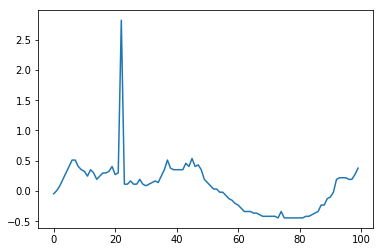

In [167]:
plt.plot(trainingData[0,:], '-')

# Model Building

- be careful to move data to the GPU during training and back to the CPU for visualization
- we need to make sure the data is in np.float32 format to matches the dtype of the model weights
- don't forget to shuffle the data during training 

In [0]:
import torch, torch.nn as nn, time
from torch.utils.data import Dataset, DataLoader

# Define DataLoaders

In [0]:
dataLoaderTrain = DataLoader( trainingData.astype('float32'), 
                                 batch_size = 16, 
                                 shuffle = True )

dataLoaderTest = DataLoader( trainingData.astype('float32'), 
                                 batch_size = 1, 
                                 shuffle = False )

# Declare Model

In [0]:
inputDimensionality = trainingData.shape[1]

model = nn.Sequential (
    nn.Linear(inputDimensionality, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//10), nn.Sigmoid(),
    nn.Linear(inputDimensionality//10, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality)
)

# Determine Target Device for Training

In [0]:
targetDeviceCPU = torch.device('cpu')
targetDeviceGPU = torch.device('cuda:0') 
targetDevice = targetDeviceGPU

# Training Loop

In [0]:
def train_model ( model, dataLoader, targeDevice, nEpochs = 10 ):

    model = model.to( targetDevice )
    
    lossFunction = nn.MSELoss()
    optimizer = torch.optim.Adam( model.parameters() )
    lossHistory = []
    
    # training loop    
    for iEpoch in range(nEpochs):   
        cumulativeLoss = 0
        for i, iInputBatch in enumerate( dataLoader ):
            
            # move batch data to target training device [ cpu or gpu ]
            iInputBatch = iInputBatch.to( targetDevice )
            
            # zero/reset the parameter gradient buffers to avoid accumulation [ usually accumulation is necessary for temporally unrolled networks ]
            optimizer.zero_grad()

            # generate predictions/reconstructions
            predictions = model.forward(iInputBatch)

            # compute error 
            loss = lossFunction( predictions, iInputBatch )
            cumulativeLoss += loss.item() # gets scaler value held in the loss tensor
            
            # compute gradients by propagating the error backward through the model/graph
            loss.backward()

            # apply gradients to update model parameters
            optimizer.step()
            
        print( 'epoch {} of {} -- avg batch loss: {}'.format(iEpoch, nEpochs, cumulativeLoss))
        
        lossHistory += [ cumulativeLoss ]
    return model, lossHistory

### Run Training Loop

In [175]:
startTime = time.time()

model, lossHistory = train_model( model, dataLoaderTrain, targetDevice, nEpochs = 50 )

print('elapsed time : {} '.format(time.time() - startTime))

epoch 0 of 50 -- avg batch loss: 1123.6955893784761
epoch 1 of 50 -- avg batch loss: 752.9724808931351
epoch 2 of 50 -- avg batch loss: 297.9802856743336
epoch 3 of 50 -- avg batch loss: 186.0948944762349
epoch 4 of 50 -- avg batch loss: 165.98227416351438
epoch 5 of 50 -- avg batch loss: 158.28766551613808
epoch 6 of 50 -- avg batch loss: 153.4979228824377
epoch 7 of 50 -- avg batch loss: 150.09143470227718
epoch 8 of 50 -- avg batch loss: 147.06661741063
epoch 9 of 50 -- avg batch loss: 144.33769621700048
epoch 10 of 50 -- avg batch loss: 141.7791625149548
epoch 11 of 50 -- avg batch loss: 139.36143758147955
epoch 12 of 50 -- avg batch loss: 137.27519825473428
epoch 13 of 50 -- avg batch loss: 135.13694748654962
epoch 14 of 50 -- avg batch loss: 133.07088087126613
epoch 15 of 50 -- avg batch loss: 130.8856831304729
epoch 16 of 50 -- avg batch loss: 129.26011243090034
epoch 17 of 50 -- avg batch loss: 127.47219888493419
epoch 18 of 50 -- avg batch loss: 126.03793976828456
epoch 19 of 

### Visualize Progression of Learning

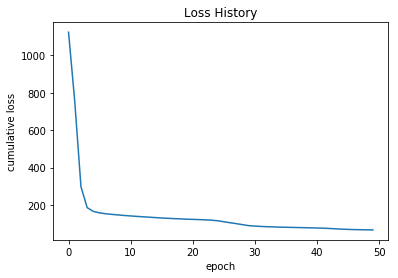

In [176]:
plt.plot(lossHistory)
plt.title('Loss History'); plt.xlabel('epoch'); plt.ylabel('cumulative loss');

# Evaluate Model Performance

Simple demo using a single sample 

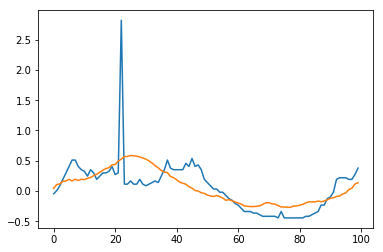

In [177]:
sample = iter(dataLoaderTest).next()[0] # get first element from sample batch        
reconstruction = model.forward(sample.to(targetDevice))
plt.plot(sample.numpy())
plt.plot(reconstruction.data.cpu().numpy())

We can also build an evaluation function that displays results and allows for multiple inferences

In [0]:
def evaluate_model ( model, dataLoader, targetDevice, nEvals = 3):

    for iSample in range(nEvals):

        sample = iter(dataLoader).next()[0] # get first element from sample batch        
        reconstruction = model.forward(sample.to(targetDevice))

        sampleNumpy = sample.numpy()
        reconstructionNumpy = reconstruction.data.cpu().numpy()
        error = np.sqrt( (reconstructionNumpy - sampleNumpy)**2 )

        plt.figure(figsize=(9,5))
        ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
        ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1, sharex=ax1)    

        ax1.plot(sampleNumpy)
        ax1.plot(reconstructionNumpy, '-.')
        ax1.set_title('sample {}, total error {}'.format(iSample, np.sum(error)))
        ax1.legend(['input data', 'reconstruction'])

        ax2.plot(error)
        ax2.legend( ['reconstruction error'] )


In [0]:
def find_anomaly(model,dataLoader,targetDevice):
    sample = iter(dataLoaderTest).next()
    reconstruction = model.forward(sample.to(targetDevice))
    sampleNumpy = sample.numpy()
    reconstructionNumpy = reconstruction.data.cpu().numpy()
    error = np.sqrt( (reconstructionNumpy - sampleNumpy)**2 )
    anom = np.where(error > 1.8, 1, 0)

    return anom

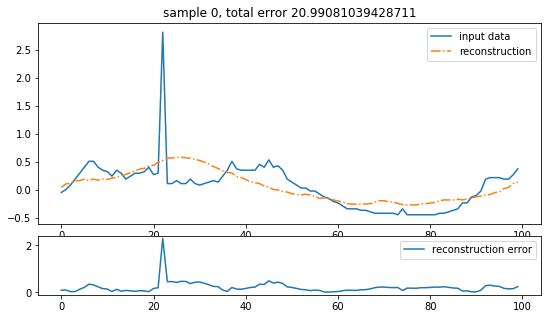

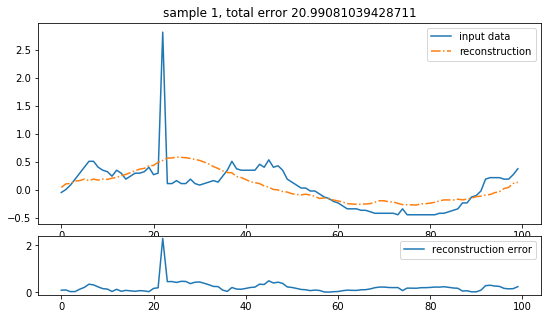

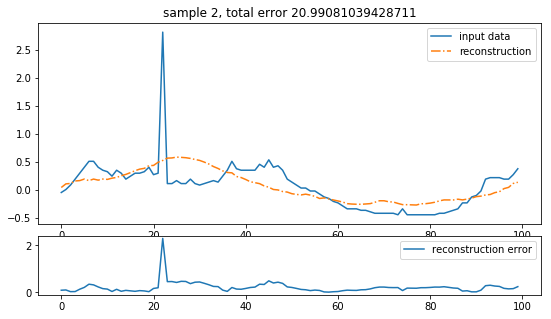

In [201]:
evaluate_model( model, dataLoaderTest, targetDeviceGPU)

In [199]:
anomaly_ar = find_anomaly( model, dataLoaderTest, targetDeviceGPU)[0]

anomaly_locations = np.where(anomaly_ar == 1)[0] 
anomaly_locations

array([22])

In [180]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
modelPath = "modelco2_2.pth"
path = F"/content/gdrive/My Drive/Interview-ML/" + modelPath 
torch.save(model.state_dict(), path)

# TODO: Inject Synthetic Anomalies
- morph 
- replace
- swap

# Advanced Architecture Construction

Note we can also build separate encoder and decoder modules, and combine them together into a final model. This is useful if we want to extract bottleneck activations

'''
# FYI this is also possible
inputDimensionality = trainingData.shape[1]
encoderModel = nn.Sequential(
    nn.Linear(inputDimensionality, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//10), nn.Sigmoid()
)
decoderModel = nn.Sequential(
    nn.Linear(inputDimensionality//10, inputDimensionality//4), nn.Sigmoid(),
    nn.Linear(inputDimensionality//4, inputDimensionality//2), nn.Sigmoid(),
    nn.Linear(inputDimensionality//2, inputDimensionality)
)

# combine
list_of_layers = list(encoderModel.children())
list_of_layers.extend(list(decoderModel.children()))
model = nn.Sequential (*list_of_layers)

# sanity check
list( nn.Sequential(*list(model.children())[0:6]).parameters() ) == list(encoderModel.parameters())
'''